# Modeling - ethereum - v3 - CatBoot

# Setup

## Library import
We import all the required Python libraries

In [33]:
import os

# Data manipulation
from feature_engine.encoding import RareLabelEncoder, CountFrequencyEncoder
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool
from lightgbm import (
    LGBMClassifier, plot_importance, create_tree_digraph, plot_tree
)
import missingno as msno
# from pycaret.classification import ClassificationExperiment
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import RFECV
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, cross_validate, KFold
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn import set_config

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Options for pandas
set_config(transform_output = "pandas")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.5f}'.format)
# pd.options.display.float_format = '{:.5f}'.format
# pd.options.display.max_rows = 120

sns.set_context(context='paper', font_scale=2, rc=None)
sns.set_style("ticks")
sns.set_palette(sns.color_palette())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Local library import
We import all the required local libraries libraries

In [34]:
os.chdir('../')
from src.utils.data_describe import breve_descricao, serie_nulos, cardinalidade, check_for_equal_columns
os.chdir('./notebooks/')

def round_4(x):
    return x.round(4)

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [35]:
RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
PROCESSED_FOLDER = '../data/processed/'
REPORTS_FOLDER = '../reports/'
RANDOM_STATE = 42

train_size = 0.15

# palette = sns.color_palette("Spectral", as_cmap=True)
palette = sns.color_palette("husl", 10)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]

# Experience 01 - Only numerical attributes

## Data import

In [36]:
df_train_exp_01 = pd.read_parquet(INTERIM_FOLDER + 'df_train_exp_01.pqt')
df_test_exp_01 = pd.read_parquet(INTERIM_FOLDER + 'df_test_exp_01.pqt')

display(df_train_exp_01.head(3))

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name
0,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31000,34.12000,4815.43000,3,13,0,10,3,1.00000,2.50105,1.34844,1.00087,11.27787,5.84292,16,17.52875,17.52978,0.00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50000,834.77000,9622.53000,2,2,0,1,2,0.58627,0.94751,0.76689,0.58541,0.94728,0.76635,4,1.53269,1.53378,0.00109,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000
2,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90000,31.87000,321.42000,2,3,0,3,1,0.00102,0.81780,0.43961,0.50039,0.81751,0.65895,5,1.31790,1.31882,0.00092,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000


# CatBoost - Categorical features encoded by frequency

## Data import

In [37]:
df_raw = pd.read_parquet(INTERIM_FOLDER + 'ethereum_complete.pqt')

df_train_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_cleaned_train_exp_02_transformed.pqt')
df_test_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_cleaned_test_exp_02_transformed.pqt')

X_train_exp_02 = df_train_exp_02.drop(columns=['FLAG'])
y_train_exp_02 = df_train_exp_02[['FLAG']]

X_test_exp_02 = df_test_exp_02.drop(columns=['FLAG'])
y_test_exp_02 = df_test_exp_02[['FLAG']]

print(f"""
X_train_exp_02: {X_train_exp_02.shape}
y_train_exp_02: {y_train_exp_02.shape}

X_test_exp_02: {X_test_exp_02.shape}
y_test_exp_02: {y_test_exp_02.shape}
""")

display(X_train_exp_02.head(3))


X_train_exp_02: (3974, 36)
y_train_exp_02: (3974, 1)

X_test_exp_02: (702, 36)
y_test_exp_02: (702, 1)



,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
3692,0.00000,0.00000,537.60000,1,1,0,1,1,1.99000,1.99000,1.99000,1.98975,1.98975,1.98975,2,1.98975,1.99000,0.00025,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89155,0.51636
152,23488.73000,33.36000,48178.53000,2,36,0,26,2,0.01038,9.99000,1.33005,0.07579,48.30435,24.19007,38,48.38014,47.88187,-0.49828,2.00000,1.33700,0.00000,0.00000,0.00000,2.00000,2.00000,0.00000,0.00000,1.33700,0.66850,0.00000,0.00000,0.00000,0.00000,2.00000,0.89155,0.16709
1175,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.33700,0.76024,0.00000,0.00000,0.00000,0.00000,1.00000,0.89155,0.51636


## Random search

In [38]:
# Search space for the random search step 

dct_params = dict(
    depth = [4, 6, 8, 10],
    learning_rate = [0.001, 0.01, 0.1],
    iterations = [100, 200, 300],
    l2_leaf_reg = [1, 3, 5],
    border_count = [32, 64, 128],
    random_strength = [0.1, 1, 10]
)

dct_params

{'depth': [4, 6, 8, 10],
 'learning_rate': [0.001, 0.01, 0.1],
 'iterations': [100, 200, 300],
 'l2_leaf_reg': [1, 3, 5],
 'border_count': [32, 64, 128],
 'random_strength': [0.1, 1, 10]}

In [39]:
classifier_cat = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=0,
    early_stopping_rounds=20
)

rscv = RandomizedSearchCV(
    classifier_cat,
    dct_params,
    n_iter=50,
    cv=10,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    error_score='raise',
    return_train_score=True
)

search = rscv.fit(X_train_exp_02, y_train_exp_02['FLAG'].values)

best_rscv = search.best_params_
best_rscv

{'random_strength': 1,
 'learning_rate': 0.1,
 'l2_leaf_reg': 3,
 'iterations': 300,
 'depth': 4,
 'border_count': 32}

In [40]:
df_random_search_results = pd.DataFrame.from_dict(rscv.cv_results_, orient='columns')[[
    'rank_test_score',
    'param_random_strength','param_learning_rate','param_l2_leaf_reg','param_iterations','param_depth','param_border_count',
    'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score',
    'mean_train_score', 'std_train_score'
    ]]

df_random_search_results.sort_values(by=['rank_test_score'], ascending=True)[:10]

,rank_test_score,param_random_strength,param_learning_rate,param_l2_leaf_reg,param_iterations,param_depth,param_border_count,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,mean_train_score,std_train_score
1,1,1.00000,0.10000,3,300,4,32,0.76407,0.05998,0.00518,0.00339,0.99893,0.00060,1.00000,0.00000
12,2,10.00000,0.10000,3,300,6,128,1.15945,0.09203,0.00294,0.00236,0.99886,0.00069,1.00000,0.00000
3,3,10.00000,0.10000,5,300,6,64,0.91491,0.05742,0.00579,0.00491,0.99882,0.00060,1.00000,0.00000
15,4,0.10000,0.10000,1,100,6,64,0.31878,0.01149,0.00245,0.00304,0.99871,0.00081,1.00000,0.00000
9,5,1.00000,0.10000,5,300,8,128,2.20432,0.05719,0.00397,0.00472,0.99869,0.00077,1.00000,0.00000
44,6,0.10000,0.10000,3,100,6,32,0.33219,0.02364,0.00447,0.00085,0.99861,0.00081,1.00000,0.00000
22,7,0.10000,0.10000,1,100,8,32,0.42508,0.03096,0.00372,0.00246,0.99861,0.00078,1.00000,0.00000
6,8,1.00000,0.10000,1,200,10,32,1.59029,0.04059,0.00455,0.00474,0.99858,0.00081,1.00000,0.00000
11,9,0.10000,0.01000,1,300,8,128,2.21945,0.07530,0.00444,0.00486,0.99856,0.00082,0.99999,0.00000
23,10,0.10000,0.10000,5,200,10,32,1.69964,0.10319,0.00429,0.00330,0.99851,0.00093,1.00000,0.00000


### mean_test_score vs n_estimators vs param_learning_rate

In [41]:
# Defining palette
n_colors = df_random_search_results['param_learning_rate'].nunique()
palette = sns.color_palette("husl", n_colors)

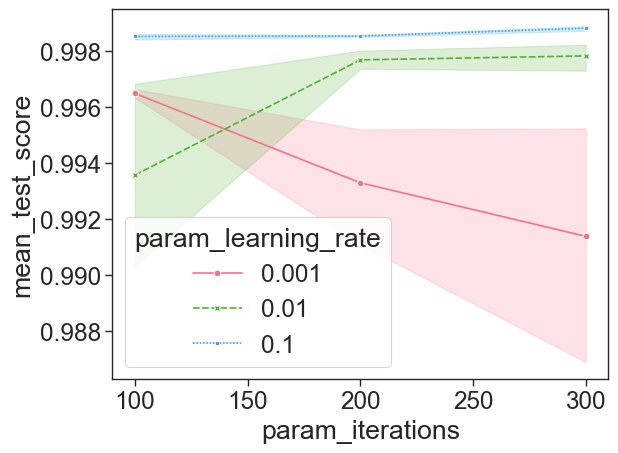

In [42]:
sns.lineplot(
    data=df_random_search_results, x='param_iterations', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True
);

### mean_test_score vs param_num_leaves vs param_learning_rate

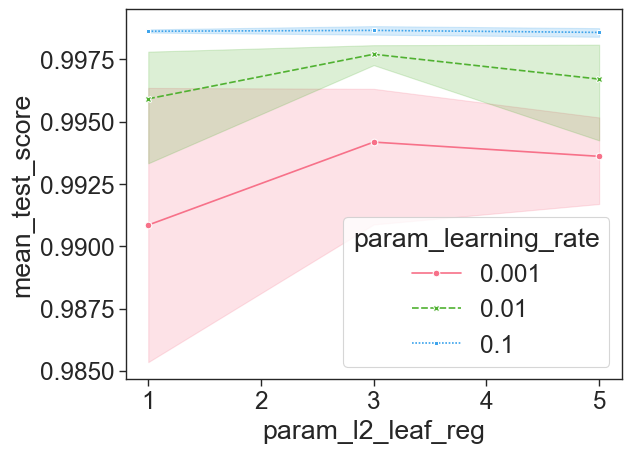

In [43]:
sns.lineplot(
    data=df_random_search_results, x='param_l2_leaf_reg', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True
);

### mean_test_score vs param_max_depth vs param_learning_rate

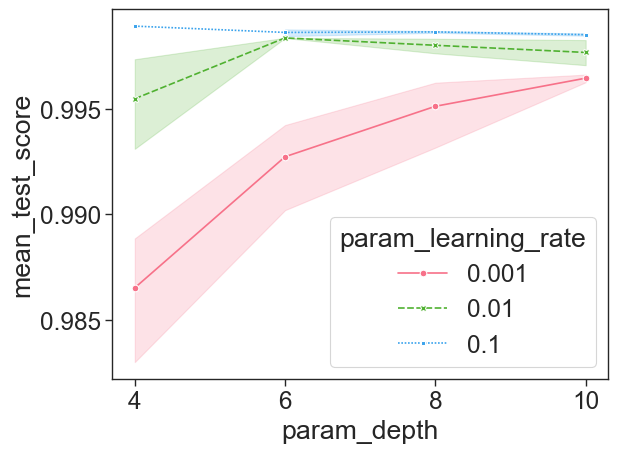

In [44]:
sns.lineplot(
    data=df_random_search_results, x='param_depth', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True
);

### For param_learning_rate = 0.1

#### mean_test_score vs param_max_depth vs param_num_leaves

In [45]:
# Defining palette
n_colors = df_random_search_results.loc[
    df_random_search_results['param_learning_rate']==best_rscv['learning_rate'], 'param_l2_leaf_reg'
].nunique()
palette = sns.color_palette("husl", n_colors)

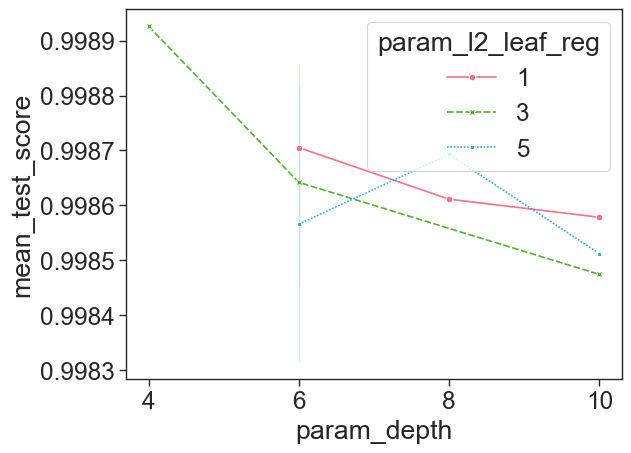

In [46]:
sns.lineplot(
    data=df_random_search_results.loc[df_random_search_results['param_learning_rate']==best_rscv['learning_rate'], :],
    x='param_depth', y='mean_test_score', hue='param_l2_leaf_reg',
    palette=palette, style="param_l2_leaf_reg", markers=True
);

#### mean_test_score vs param_max_depth vs param_n_estimators

In [47]:
# Defining palette
n_colors = df_random_search_results['param_iterations'].nunique()
palette = sns.color_palette("husl", n_colors)

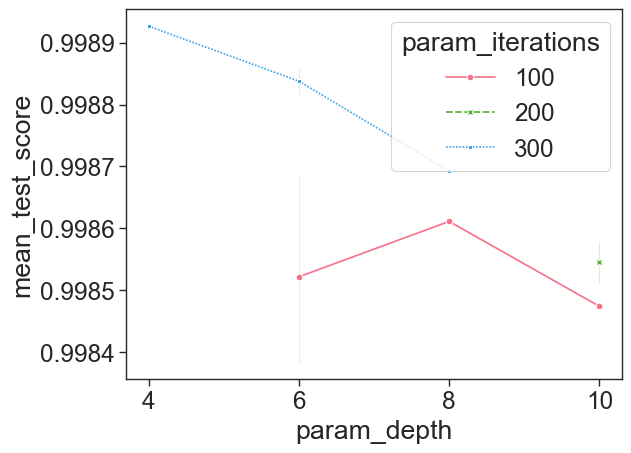

In [48]:
sns.lineplot(
    data=df_random_search_results.loc[df_random_search_results['param_learning_rate']==best_rscv['learning_rate'], :],
    x='param_depth', y='mean_test_score', hue='param_iterations',
    palette=palette, style="param_iterations", markers=True
);

## Grid search

In [49]:
dct_params = dict(
    depth=np.arange(max(best_rscv['depth'], 2), best_rscv['depth']+4, 1),
    l2_leaf_reg=np.arange(best_rscv['l2_leaf_reg'], best_rscv['l2_leaf_reg']+10, 4),
    iterations = np.arange(best_rscv['iterations']-25, best_rscv['iterations']+50, 25).tolist(),
    learning_rate=np.arange(
        best_rscv['learning_rate']*.5, best_rscv['learning_rate']*1.5,
        best_rscv['learning_rate'] / 4
    )
)

dct_params

{'depth': array([4, 5, 6, 7]),
 'l2_leaf_reg': array([ 3,  7, 11]),
 'iterations': [275, 300, 325],
 'learning_rate': array([0.05 , 0.075, 0.1  , 0.125, 0.15 ])}

In [50]:
classifier_cat = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=0,
    early_stopping_rounds=20
)

gscv = RandomizedSearchCV(
    classifier_cat,
    dct_params,
    n_iter=50,
    cv=10,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    error_score='raise',
    return_train_score=True
)

grid_search = gscv.fit(X_train_exp_02, y_train_exp_02)
best_gscv = grid_search.best_params_
best_gscv

{'learning_rate': 0.12500000000000003,
 'l2_leaf_reg': 3,
 'iterations': 275,
 'depth': 6}

In [51]:
df_grid_search_results = pd.DataFrame.from_dict(gscv.cv_results_, orient='columns')[[
    'rank_test_score', 'param_l2_leaf_reg', 'param_iterations', 'param_depth', 'param_learning_rate',
    'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score',
    'mean_train_score', 'std_train_score'
]]

# Rounding df
df_grid_search_results['param_learning_rate'] = df_grid_search_results['param_learning_rate']

df_grid_search_results.sort_values(by=['rank_test_score'], ascending=True)[:10]

,rank_test_score,param_l2_leaf_reg,param_iterations,param_depth,param_learning_rate,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,mean_train_score,std_train_score
10,1,3,275,6,0.12500,1.26651,0.04529,0.00488,0.00214,0.99892,0.00065,1.00000,0.00000
15,2,3,300,4,0.07500,0.82516,0.02034,0.00507,0.00210,0.99892,0.00061,1.00000,0.00000
39,3,3,325,4,0.07500,0.90809,0.03689,0.00395,0.00274,0.99891,0.00063,1.00000,0.00000
24,4,7,275,4,0.15000,0.73104,0.04318,0.00585,0.00273,0.99891,0.00064,1.00000,0.00000
6,5,7,300,4,0.15000,0.87503,0.04227,0.00502,0.00133,0.99889,0.00066,1.00000,0.00000
41,6,11,325,4,0.07500,0.91283,0.05173,0.00357,0.00198,0.99887,0.00053,0.99997,0.00001
48,7,3,325,7,0.15000,2.13206,0.04471,0.00786,0.00248,0.99887,0.00075,1.00000,0.00000
42,8,3,325,6,0.15000,1.48748,0.07238,0.00672,0.00253,0.99884,0.00068,1.00000,0.00000
26,9,3,300,5,0.05000,1.01720,0.05875,0.00598,0.00421,0.99884,0.00064,1.00000,0.00000
46,10,3,275,6,0.05000,1.27518,0.08534,0.00474,0.00286,0.99884,0.00063,1.00000,0.00000


### mean_test_score vs n_estimators vs param_learning_rate

In [52]:
# Defining palette
n_colors = df_grid_search_results['param_learning_rate'].nunique()
palette = sns.color_palette("husl", n_colors)

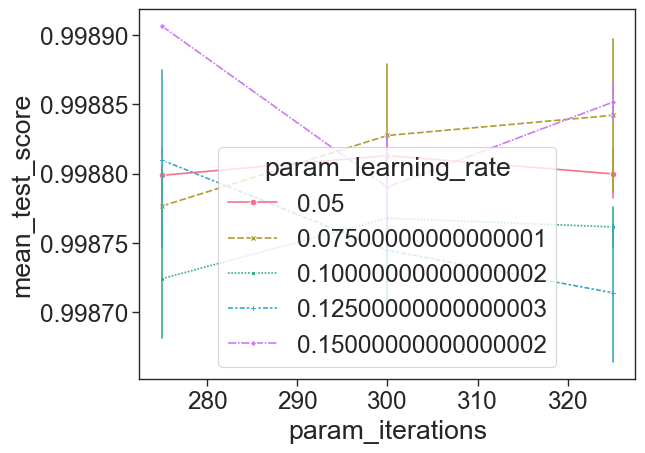

In [53]:
sns.lineplot(
    data=df_grid_search_results, x='param_iterations', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True, errorbar=('ci', 90), err_style='bars'
);

### mean_test_score vs param_num_leaves vs param_learning_rate

C:\Users\gusta\AppData\Local\Temp\ipykernel_21624\665790509.py:1: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.




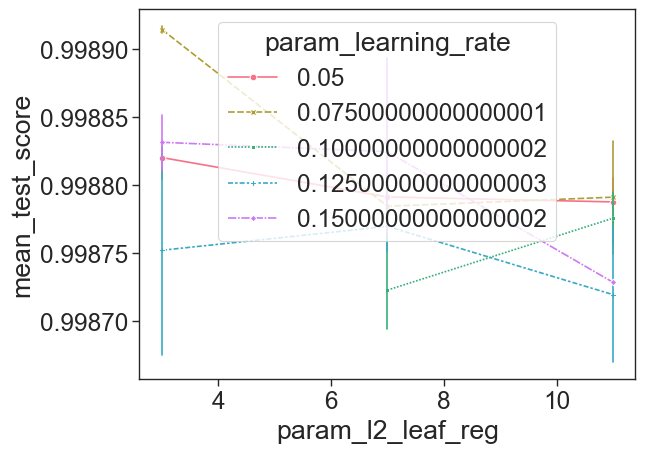

In [54]:
sns.lineplot(
    data=df_grid_search_results, x='param_l2_leaf_reg', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True, ci=90, err_style='bars'
);

### mean_test_score vs param_max_depth vs param_learning_rate

C:\Users\gusta\AppData\Local\Temp\ipykernel_21624\931288286.py:1: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.




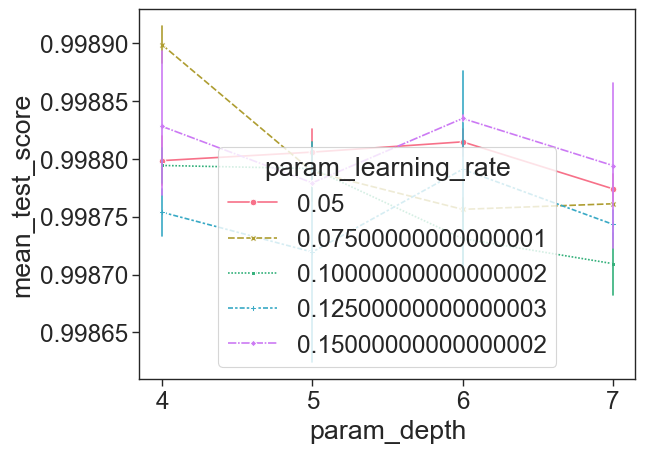

In [55]:
sns.lineplot(
    data=df_grid_search_results, x='param_depth', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True, ci=90, err_style='bars'
);

### For param_learning_rate = 0.0750

#### mean_test_score vs param_max_depth vs param_num_leaves

In [56]:
best_learning_rate = round(best_gscv['learning_rate'], 4)
best_learning_rate

0.125

In [57]:
# Defining palette
n_colors = df_grid_search_results['param_l2_leaf_reg'].nunique()
palette = sns.color_palette("husl", n_colors)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744)]

C:\Users\gusta\AppData\Local\Temp\ipykernel_21624\2787352868.py:1: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



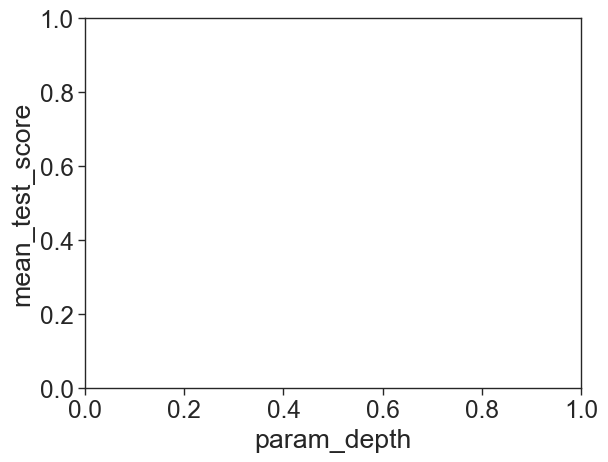

In [58]:
sns.lineplot(
    data=df_grid_search_results.loc[df_grid_search_results['param_learning_rate']==best_learning_rate, :],
    x='param_depth', y='mean_test_score', hue='param_l2_leaf_reg', errorbar=('ci', 90), err_style='bars',
    palette=palette, style="param_l2_leaf_reg", markers=True
);

#### mean_test_score vs param_max_depth vs param_n_estimators

In [59]:
# Defining palette
n_colors = df_grid_search_results['param_iterations'].nunique()
palette = sns.color_palette("husl", n_colors)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744)]

C:\Users\gusta\AppData\Local\Temp\ipykernel_21624\1857575202.py:1: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



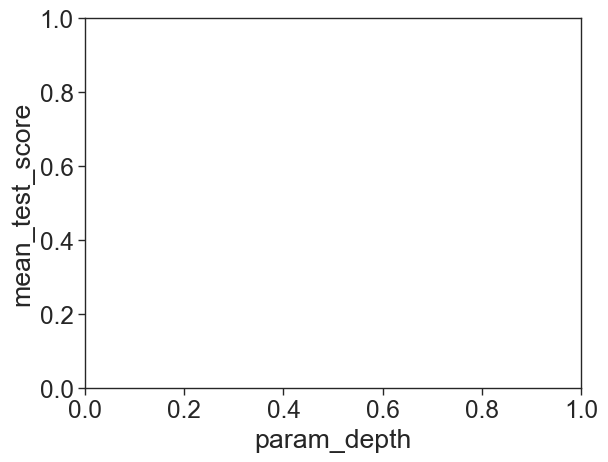

In [60]:
sns.lineplot(
    data=df_grid_search_results.loc[df_grid_search_results['param_learning_rate']==best_learning_rate, :],
    x='param_depth', y='mean_test_score', hue='param_iterations', errorbar=('ci', 90), err_style='bars',
    palette=palette, style="param_iterations", markers=True
);

## AUC vs n_estimators vs depth

- 10-fold cross validation

In [61]:
X_exp_02 = pd.concat([X_train_exp_02, X_test_exp_02], axis=0)
y_exp_02 = pd.concat([y_train_exp_02, y_test_exp_02], axis=0)

X_exp_02 = X_train_exp_02.copy()
y_exp_02 = y_train_exp_02.copy()

In [62]:
try:
    print(best_gscv)

except:
    best_gscv = {
        'learning_rate': 0.07500000000000001, 'depth': 4,
        'iterations': 275,'l2_leaf_reg': 26
    }

{'learning_rate': 0.12500000000000003, 'l2_leaf_reg': 3, 'iterations': 275, 'depth': 6}


In [63]:


best_params = dict(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='split',
    learning_rate=best_gscv['learning_rate'], num_leaves=best_gscv['l2_leaf_reg']
)

best_params

{'random_state': 42,
 'n_jobs': -1,
 'silent': 'warn',
 'objective': 'binary',
 'importance_type': 'split',
 'learning_rate': 0.12500000000000003,
 'num_leaves': 3}

# 🚧

In [32]:
scoring='roc_auc'
dct_results = {}

# for n_estimator in np.arange(50, 600, 25).tolist():
for n_estimator in np.arange(75, 450, 25).tolist():
# for n_estimator in [100]:
#     for depth in [3, 4, 5, 13, 23, 33]:
    for depth in [3, 4, 5, 6, 8, 13, 18, 23, 28, 33]:
        classifier_cat = CatBoostClassifier(
            random_state=RANDOM_STATE,
            verbose=0,
            early_stopping_rounds=20,
            **best_params
        )

        cross = cross_validate(
            estimator=classifier_cat, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
            n_jobs=-1, verbose=0, return_train_score=True, 
        )

        dct_results[str(n_estimator)+'_'+str(depth)] = {
            'iterations': iterations,
            'depth': depth,
            'test_score_mean': cross['test_score'].mean(),
            'test_score_std': cross['test_score'].std(),
            'train_score_mean': cross['train_score'].mean(),
            'train_score_std': cross['train_score'].std()
        }

df_results_auc = pd.DataFrame.from_dict(dct_results, orient='index')

df_results_auc.sort_values(by='test_score_mean', ascending=False).head()

TypeError: catboost.core.CatBoostClassifier() got multiple values for keyword argument 'random_state'

In [ ]:
df_auc_estimators_depth = df_results_auc.sort_values(by=['iterations', 'depth'], ascending=True)
display(df_auc_estimators_depth)

,n_estimator,depth,test_score_mean,test_score_std,train_score_mean,train_score_std
75_3,75,3,0.99874,0.00066,0.99984,0.00002
75_4,75,4,0.99882,0.00053,0.99999,0.00000
75_5,75,5,0.99871,0.00054,1.00000,0.00000
75_6,75,6,0.99874,0.00072,1.00000,0.00000
75_8,75,8,0.99874,0.00061,1.00000,0.00000
...,...,...,...,...,...,...
425_13,425,13,0.99884,0.00075,1.00000,0.00000
425_18,425,18,0.99884,0.00075,1.00000,0.00000
425_23,425,23,0.99884,0.00075,1.00000,0.00000
425_28,425,28,0.99884,0.00075,1.00000,0.00000


### Pivotando tabela e extraindo para excel

In [ ]:
df_auc_estimators_depth_pivoted = pd.pivot_table(
    df_auc_estimators_depth, values='test_score_mean', index=['n_estimator'],
    columns=['depth'], aggfunc="mean"
).reset_index(names=['n_estimator'])

df_auc_estimators_depth_pivoted.to_excel('../data/processed/AUC vs n_estimators vs depth.xlsx', index=False)

In [ ]:
# Defining palette
n_colors = df_results_auc['depth'].nunique()
palette = sns.color_palette("husl", n_colors)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]

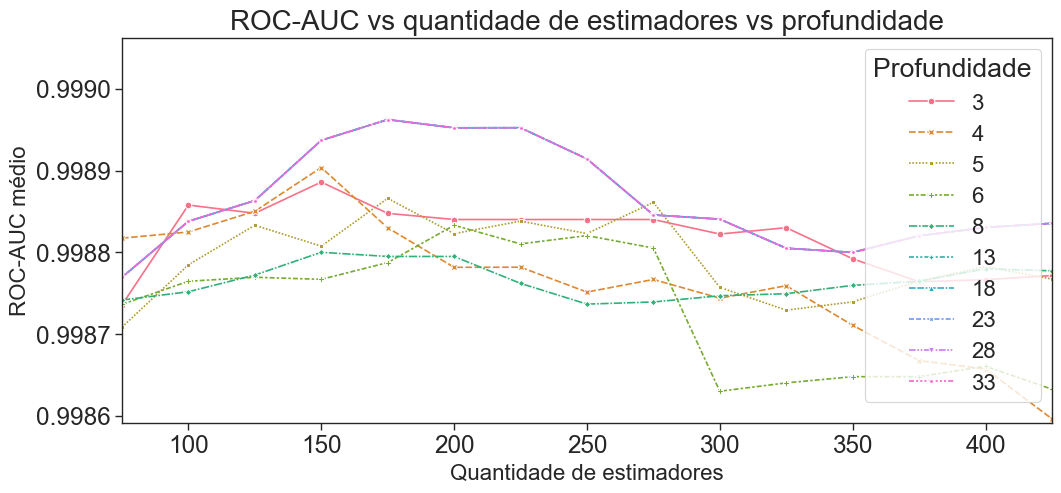

In [ ]:
plt.figure(figsize=(12, 5))

ax = sns.lineplot(
    data=df_results_auc, x='n_estimator', y='test_score_mean', hue='depth', style='depth',
    palette=palette, markers=True
)

ax.set_title("ROC-AUC vs quantidade de estimadores vs profundidade", fontsize=20)
ax.set_xlabel("Quantidade de estimadores", fontsize=16)
ax.set_ylabel("ROC-AUC médio", fontsize=16)

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1))
plt.legend(title='Profundidade', fontsize=16)
ax.set_xlim(df_results_auc['n_estimator'].min(), df_results_auc['n_estimator'].max())
ax.set_ylim(df_results_auc['test_score_mean'].min()*.999995, df_results_auc['test_score_mean'].max()*1.0001);

## Log loss vs iterations vs train-test

In [ ]:
lst_iterations = np.arange(1, 326, 4).tolist()
# lst_iterations[0] = 1
# lst_iterations

In [ ]:
scoring='neg_log_loss'
dct_results = {}
depth = best_gscv['max_depth']
n_estimator = best_gscv['n_estimators']


for n_estimator in lst_iterations:
    classifier_lgbm = LGBMClassifier(
            **best_params, n_estimators=n_estimator, max_depth=depth
        )
    
    cross = cross_validate(
        estimator=classifier_lgbm, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
        n_jobs=-1, verbose=0, return_train_score=True, 
    )

    dct_results[str(n_estimator)+'_'+str(depth)] = {
        'n_estimator': n_estimator,
        'test_score_mean': abs(cross['test_score'].mean()),
        'test_score_std': cross['test_score'].std(),
        'train_score_mean': abs(cross['train_score'].mean()),
        'train_score_std': cross['train_score'].std(),
    }

df_results_logloss = pd.DataFrame.from_dict(dct_results, orient='index')
df_results_logloss.columns = [
    'Estimadores', 'Média no conjunto de teste', 'test_score_std', 'Média no conjunto de treino', 'train_score_std'
]
df_results_logloss.head()

,Estimadores,Média no conjunto de teste,test_score_std,Média no conjunto de treino,train_score_std
1_23,1,0.57276,0.00200,0.57064,0.00057
5_23,5,0.31209,0.00569,0.30295,0.00151
9_23,9,0.19446,0.00533,0.18228,0.00068
13_23,13,0.13468,0.00531,0.11929,0.00055
17_23,17,0.10025,0.00617,0.08215,0.00072


In [ ]:
df_results_logloss.columns

Index(['Estimadores', 'Média no conjunto de teste', 'test_score_std',
       'Média no conjunto de treino', 'train_score_std'],
      dtype='object')

In [ ]:
df_results_logloss_melted = df_results_logloss[
    ['Estimadores', 'Média no conjunto de teste', 'Média no conjunto de treino']
].melt(['Estimadores'], var_name='scores', value_name='mean')

df_results_logloss_melted.sample(3, random_state=RANDOM_STATE)

,Estimadores,scores,mean
135,213,Média no conjunto de treino,0.00003
115,133,Média no conjunto de treino,0.00050
131,197,Média no conjunto de treino,0.00005


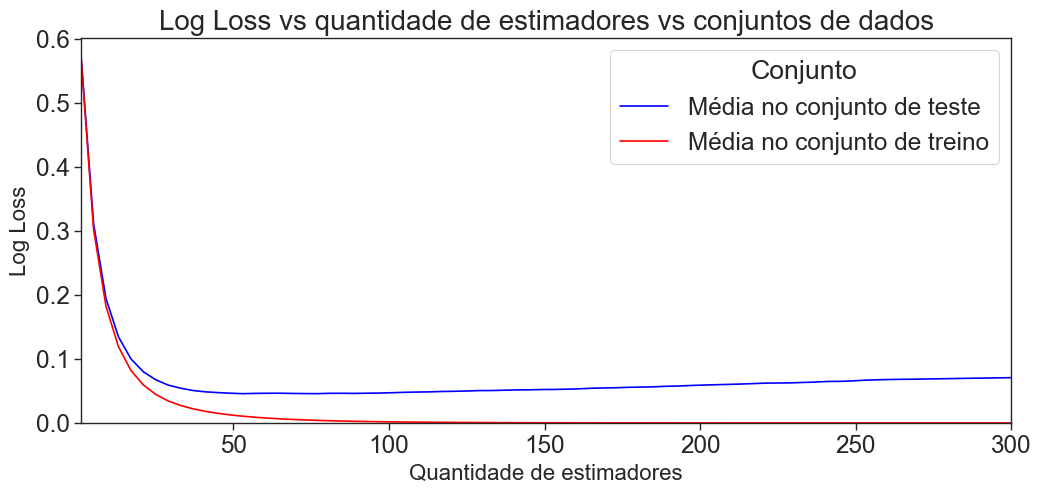

In [ ]:
plt.figure(figsize=(12, 5))

ax = sns.lineplot(
    data=df_results_logloss_melted, x='Estimadores', y='mean', hue='scores', palette=['blue', 'red']
)

ax.set_title("Log Loss vs quantidade de estimadores vs conjuntos de dados", fontsize=20)
ax.set_xlabel("Quantidade de estimadores", fontsize=16)
ax.set_ylabel("Log Loss", fontsize=16)
plt.legend(title='Conjunto', fontsize=16)

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1))
ax.set_xlim(min(lst_iterations), 300)
ax.set_ylim(0, df_results_logloss_melted['mean'].max()*1.05);

In [ ]:
df_results_logloss_cut = df_results_logloss.sort_values(by=['Estimadores'], ascending=True).copy()

df_results_logloss_cut['Média no conjunto de teste - Lead 1'] = df_results_logloss_cut['Média no conjunto de teste'].shift(-1)

df_results_logloss_cut['Delta - conjunto de teste'] = df_results_logloss_cut['Média no conjunto de teste - Lead 1'] -\
df_results_logloss_cut['Média no conjunto de teste']

df_results_logloss_cut = df_results_logloss_cut[
    ['Estimadores', 'Média no conjunto de teste', 'Delta - conjunto de teste', 'Média no conjunto de treino']
]

df_results_logloss_cut.sort_values(by=['Estimadores'], ascending=True).head(100)

,Estimadores,Média no conjunto de teste,Delta - conjunto de teste,Média no conjunto de treino
1_23,1,0.57276,-0.26067,0.57064
5_23,5,0.31209,-0.11762,0.30295
9_23,9,0.19446,-0.05978,0.18228
13_23,13,0.13468,-0.03443,0.11929
17_23,17,0.10025,-0.02030,0.08215
21_23,21,0.07994,-0.01254,0.05938
25_23,25,0.06740,-0.00834,0.04455
29_23,29,0.05906,-0.00484,0.03431
33_23,33,0.05422,-0.00361,0.02724
37_23,37,0.05061,-0.00206,0.02201


In [ ]:
df_results_logloss_cut_melted = df_results_logloss_cut[
    ['Estimadores', 'Média no conjunto de teste', 'Média no conjunto de treino', 'Delta - conjunto de teste']
].melt(['Estimadores'], var_name='scores', value_name='mean')

df_results_logloss_cut_melted.sample(3, random_state=RANDOM_STATE)

,Estimadores,scores,mean
33,133,Média no conjunto de teste,0.05057
6,25,Média no conjunto de teste,0.06740
181,69,Delta - conjunto de teste,-0.00022


In [ ]:
df_results_logloss_cut_melted.loc[
    (df_results_logloss_cut_melted['scores'].isin(['Delta - conjunto de teste'])) &
    (df_results_logloss_cut_melted['mean'] < 0.0001)
]

,Estimadores,scores,mean
164,1,Delta - conjunto de teste,-0.26067
165,5,Delta - conjunto de teste,-0.11762
166,9,Delta - conjunto de teste,-0.05978
167,13,Delta - conjunto de teste,-0.03443
168,17,Delta - conjunto de teste,-0.02030
169,21,Delta - conjunto de teste,-0.01254
170,25,Delta - conjunto de teste,-0.00834
171,29,Delta - conjunto de teste,-0.00484
172,33,Delta - conjunto de teste,-0.00361
173,37,Delta - conjunto de teste,-0.00206


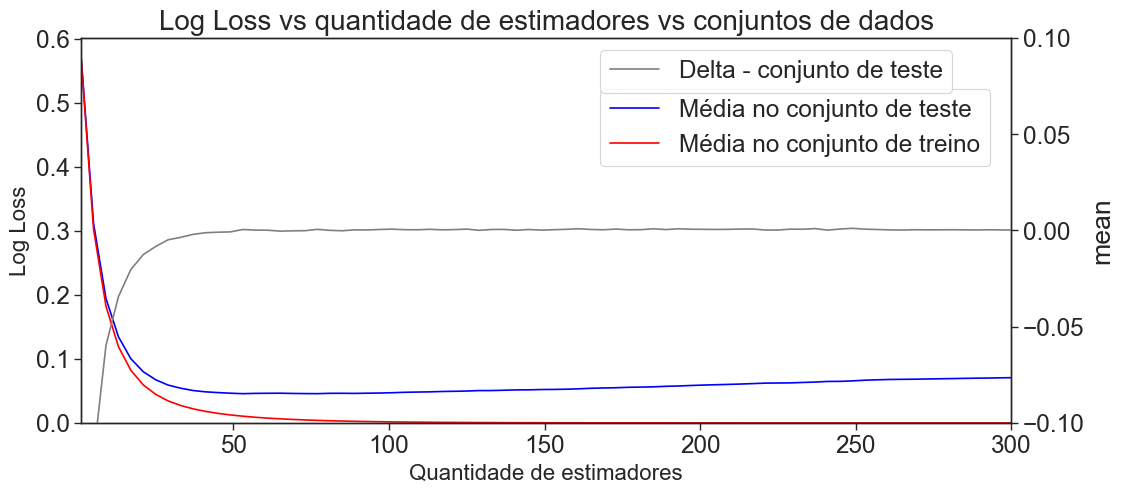

In [ ]:
plt.figure(figsize=(12, 5))

ax = sns.lineplot(
    data=df_results_logloss_cut_melted.loc[
        df_results_logloss_cut_melted['scores'].isin(['Média no conjunto de teste', 'Média no conjunto de treino'])
    ],
    x='Estimadores', y='mean', hue='scores', palette=['blue', 'red']
)
plt.legend(title='', fontsize=16)

ax2 = plt.twinx()
sns.lineplot(data=df_results_logloss_cut_melted.loc[
        df_results_logloss_cut_melted['scores'].isin(['Delta - conjunto de teste'])
    ], x='Estimadores', y='mean', hue='scores', ax=ax2, palette=['grey'])
plt.legend(title='', fontsize=16)
ax2.set_ylim(-0.1, 0.1)

ax.set_title("Log Loss vs quantidade de estimadores vs conjuntos de dados", fontsize=20)
ax.set_xlabel("Quantidade de estimadores", fontsize=16)
ax.set_ylabel("Log Loss", fontsize=16)

sns.move_legend(ax, "upper right", bbox_to_anchor=(0.99, 0.9))
sns.move_legend(ax2, "upper right", bbox_to_anchor=(0.95, 1))
ax.set_xlim(min(lst_iterations), 300)
ax.set_ylim(0, df_results_logloss_melted['mean'].max()*1.05);

## Feature importance

In [ ]:
try:
    print(best_gscv)
except:
    best_gscv = {'learning_rate': 0.07500000000000001,
     'max_depth': 4,
     'n_estimators': 275,
     'num_leaves': 26}

{'learning_rate': 0.15000000000000002, 'max_depth': 23, 'n_estimators': 225, 'num_leaves': 13}


In [ ]:
# Gain importance
classifier_lgbm_gain = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='gain', **best_gscv
)

classifier_lgbm_gain.fit(X_train_exp_02, y_train_exp_02)


# Split importance
classifier_lgbm_split = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='split', **best_gscv
)

classifier_lgbm_split.fit(X_train_exp_02, y_train_exp_02)

c:\PROJETOS NO GIT\01 - Carne de Pescoço\ethereum_laundering\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\PROJETOS NO GIT\01 - Carne de Pescoço\ethereum_laundering\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\PROJETOS NO GIT\01 - Carne de Pescoço\ethereum_laundering\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\PROJETOS NO GIT\01 - Carne de Pescoço\ethereum_laundering\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning:

A column-vector 

LGBMClassifier(learning_rate=0.15000000000000002, max_depth=23,
               n_estimators=225, n_jobs=-1, num_leaves=13, objective='binary',
               random_state=42, silent='warn')

In [ ]:
df_importance_split = pd.DataFrame(classifier_lgbm_split.feature_importances_, index=classifier_lgbm_split.feature_name_, columns=['split'])
df_importance_gain = pd.DataFrame(classifier_lgbm_gain.feature_importances_, index=classifier_lgbm_gain.feature_name_, columns=['gain'])

df_importance = pd.concat([df_importance_split, df_importance_gain], axis=1)

df_importance.to_excel(PROCESSED_FOLDER + 'df_importance.xlsx')
df_importance.head()

,split,gain
Avg_min_between_sent_tnx,39,8.28347
Avg_min_between_received_tnx,112,249.31683
Time_Diff_between_first_and_last_(Mins),287,4036.79305
Sent_tnx,63,146.13498
Received_Tnx,65,70.23770


In [ ]:
df_importance.sort_values(by='gain', ascending=False)

,split,gain
ERC20_max_val_rec,153,9288.55218
Time_Diff_between_first_and_last_(Mins),287,4036.79305
Total_ERC20_tnxs,208,1899.08632
total_transactions_(including_tnx_to_create_contract),174,762.13334
Unique_Received_From_Addresses,212,636.85744
total_ether_balance,115,615.90513
ERC20_total_Ether_received,93,348.36177
ERC20_most_rec_token_type,87,341.09080
avg_val_received,171,299.65046
Avg_min_between_received_tnx,112,249.31683


### Licit vs illicit wallets - 10 most important features

In [ ]:
lst_most_important_features = df_importance.sort_values(by=['split'], ascending=False).index.tolist()[:5]
lst_most_important_features.append('ERC20_max_val_rec')
lst_most_important_features.append('FLAG')

df_important_features = df_train_exp_02.loc[:, lst_most_important_features]
lst_most_important_features.remove('FLAG')
df_important_features.head()

,Time_Diff_between_first_and_last_(Mins),Unique_Received_From_Addresses,Total_ERC20_tnxs,total_transactions_(including_tnx_to_create_contract),avg_val_received,ERC20_max_val_rec,FLAG
3692,537.60000,1,0.00000,2,1.99000,0.00000,0
152,48178.53000,26,2.00000,38,1.33005,1.33700,1
1175,0.00000,0,1.00000,0,0.00000,1.33700,1
3874,223284.43000,1,10.00000,6,0.26620,8888.00000,0
3011,66.55000,1,0.00000,4,101.00000,0.00000,0


In [ ]:
dct_temp = {}

for column in lst_most_important_features:
    dct_temp.update({column: 'median'})
    
dct_temp

{'Time_Diff_between_first_and_last_(Mins)': 'median',
 'Unique_Received_From_Addresses': 'median',
 'Total_ERC20_tnxs': 'median',
 'total_transactions_(including_tnx_to_create_contract)': 'median',
 'avg_val_received': 'median',
 'ERC20_max_val_rec': 'median'}

In [ ]:
df_important_features_agg = df_important_features.groupby(by=['FLAG']).agg(dct_temp).reset_index()

df_important_features_agg

,FLAG,Time_Diff_between_first_and_last_(Mins),Unique_Received_From_Addresses,Total_ERC20_tnxs,total_transactions_(including_tnx_to_create_contract),avg_val_received,ERC20_max_val_rec
0,0,41215.77000,2.00000,0.00000,8.00000,7.54027,0.00000
1,1,7539.27000,3.00000,1.00000,5.00000,0.50013,1.33700


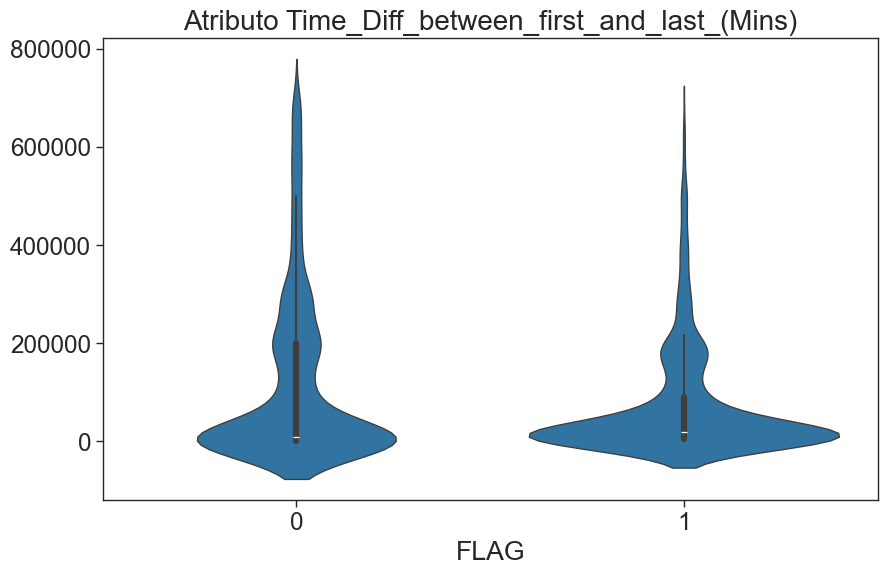

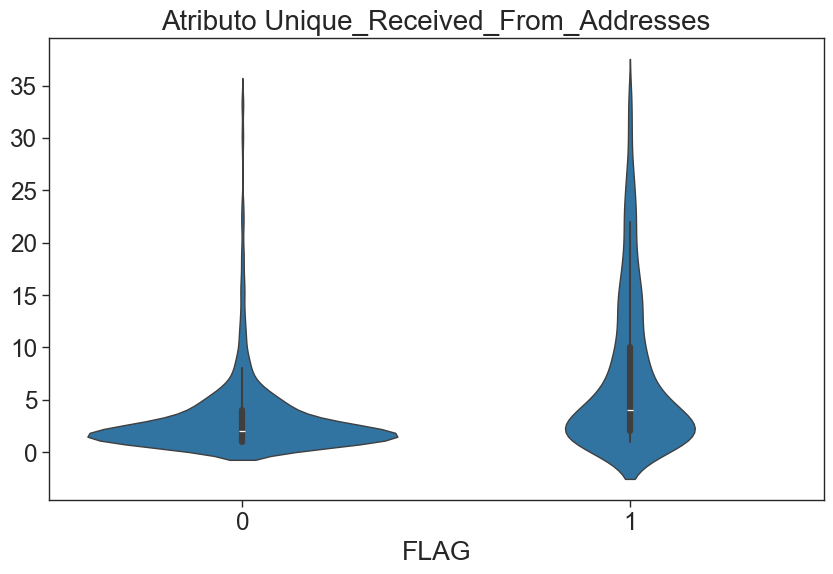

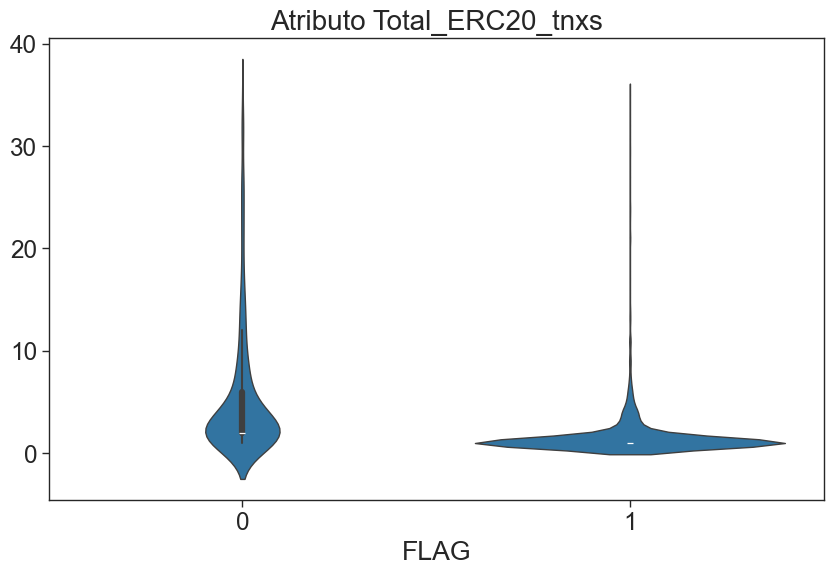

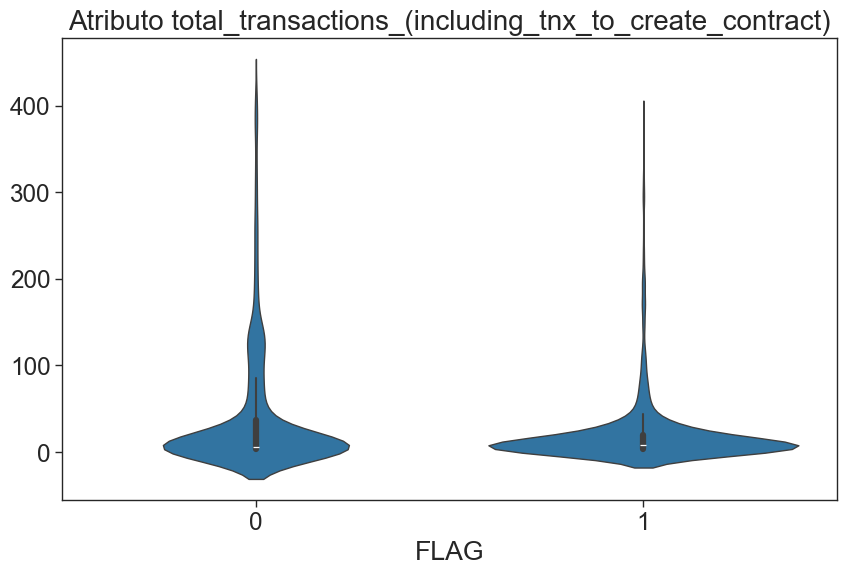

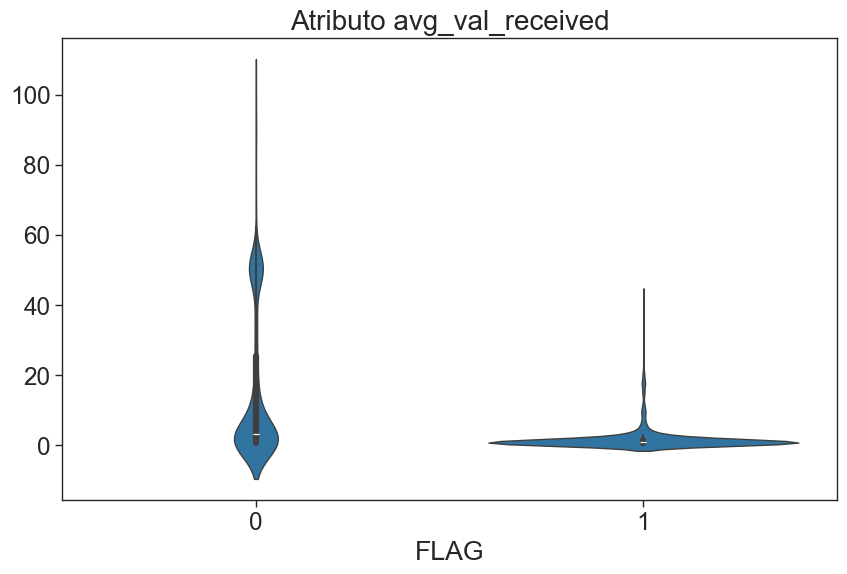

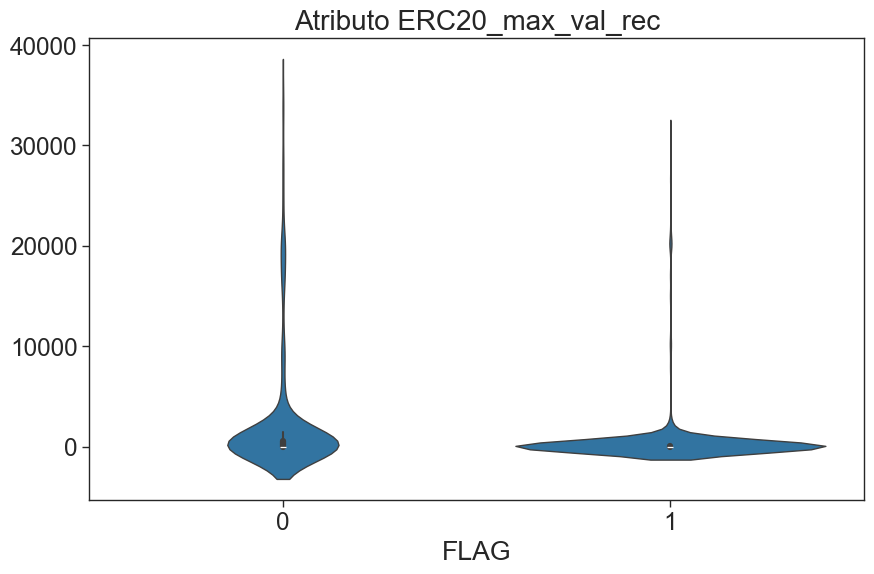

In [ ]:
for column in lst_most_important_features: 
    max_lim = np.percentile(df_important_features[column], 95)
    min_lim = np.percentile(df_important_features[column], 5)

    plt.figure(figsize=(10, 6))
    # plt.ylim(-100, 550000)

    ax = sns.violinplot(data=df_important_features.loc[
        (df_important_features[column] < max_lim) &
        (df_important_features[column] > min_lim)
    ], x='FLAG', y=column)
    ax.set_title(f"Atributo {column}", fontsize=20)
    ax.set_ylabel(None)


    plt.show();

C:\Users\gusta\AppData\Local\Temp\ipykernel_21296\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




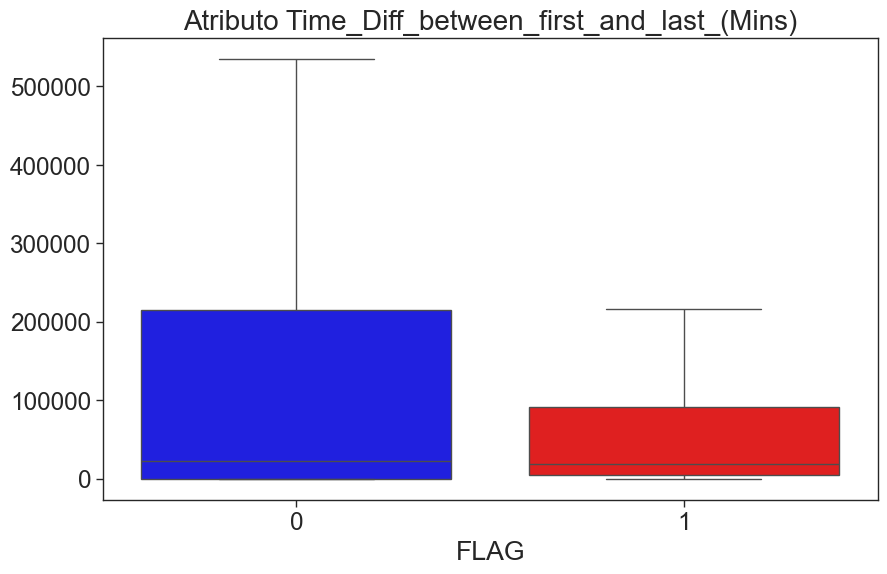

C:\Users\gusta\AppData\Local\Temp\ipykernel_21296\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




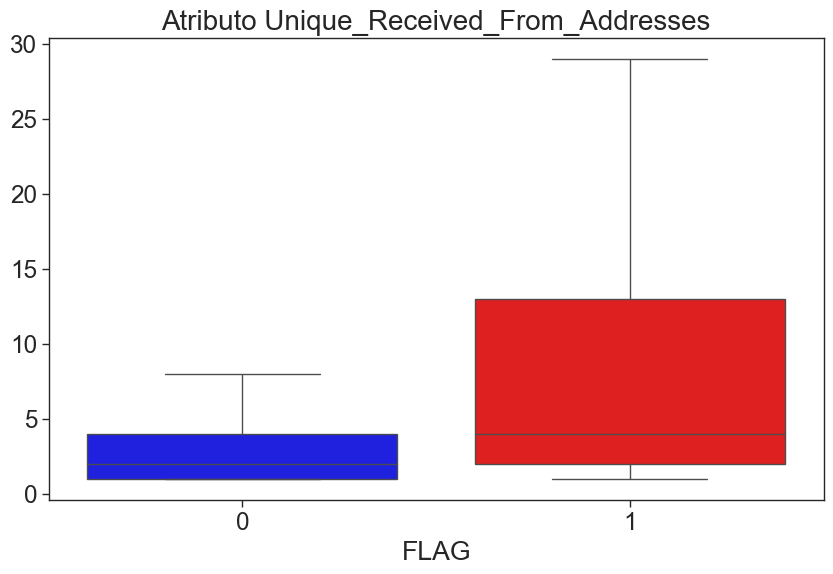

C:\Users\gusta\AppData\Local\Temp\ipykernel_21296\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




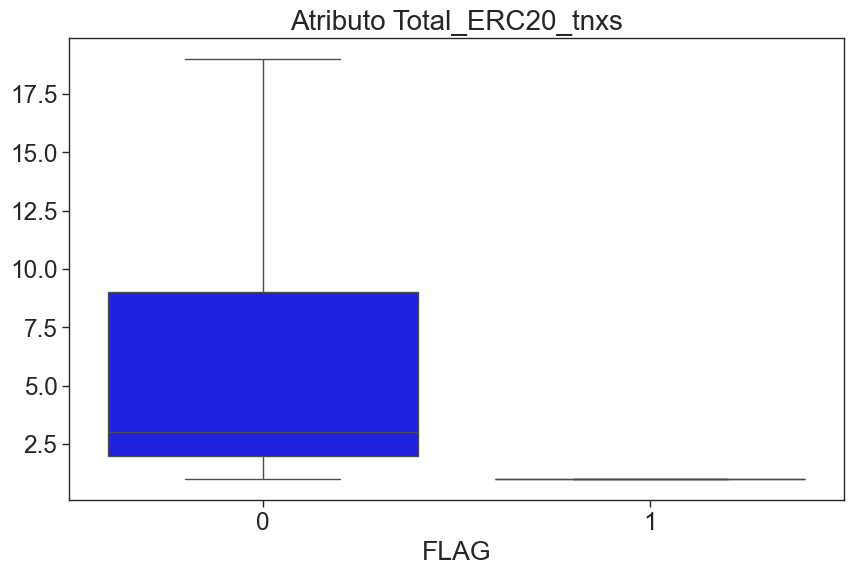

C:\Users\gusta\AppData\Local\Temp\ipykernel_21296\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




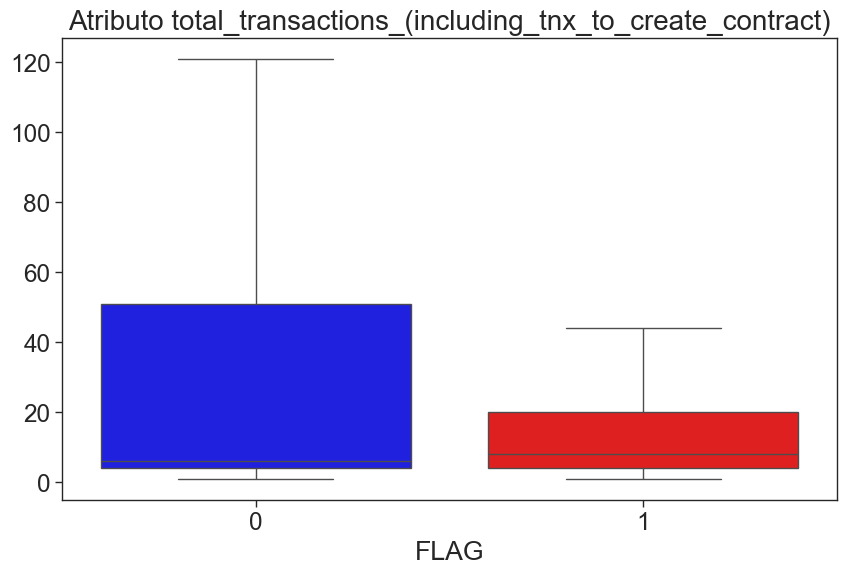

C:\Users\gusta\AppData\Local\Temp\ipykernel_21296\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




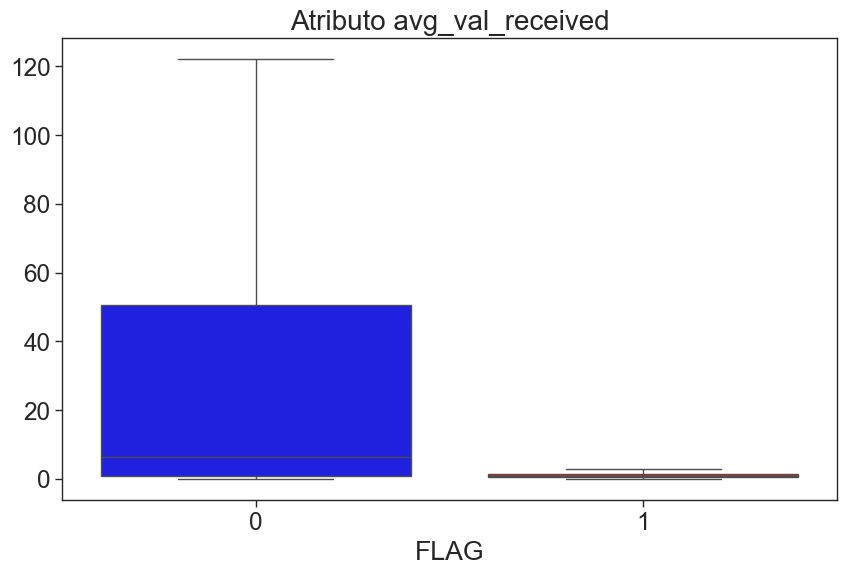

C:\Users\gusta\AppData\Local\Temp\ipykernel_21296\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




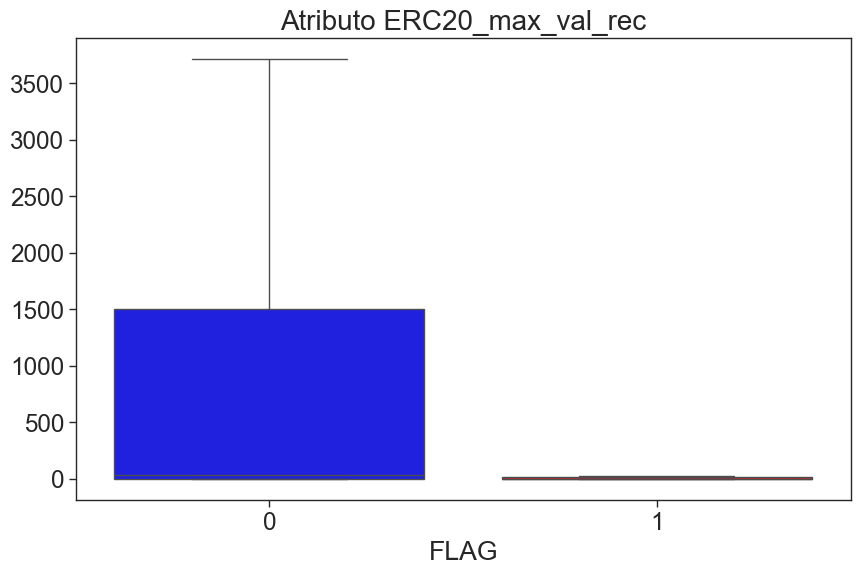

In [ ]:
for column in lst_most_important_features: 
    max_lim = np.percentile(df_important_features[column], 97.5)
    min_lim = np.percentile(df_important_features[column], 2.5)

    plt.figure(figsize=(10, 6))
    # plt.ylim(-100, 550000)

    ax = sns.boxplot(data=df_important_features.loc[
        (df_important_features[column] < max_lim) &
        (df_important_features[column] > min_lim)
    ], x='FLAG', y=column, palette=['b', 'r'], showfliers = False)
    ax.set_title(f"Atributo {column}", fontsize=20)
    ax.set_ylabel(None)


    plt.show();

In [ ]:
df_important_features.to_excel('../data/processed/Comparação para cada feature mais importante.xlsx', index=False)

### Split importance

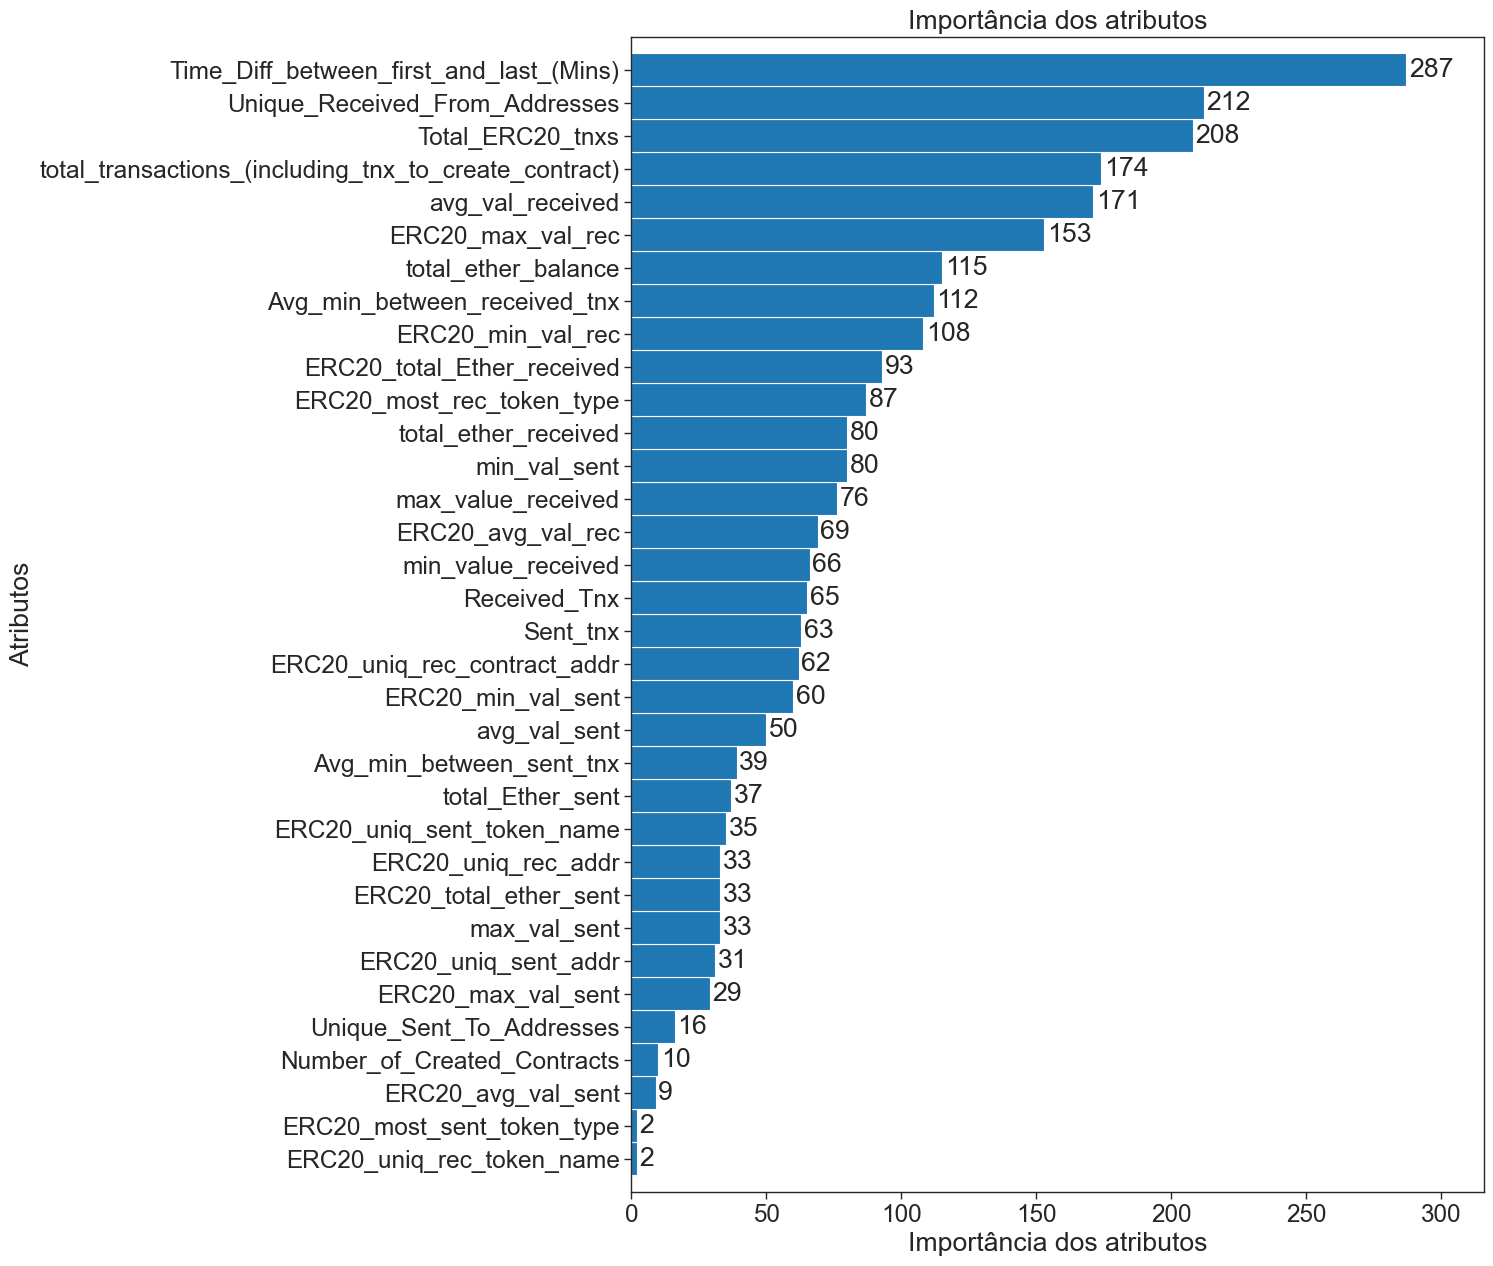

In [ ]:
plot_importance(
    classifier_lgbm_split, height=1, xlim=None, ylim=None,
    title='Importância dos atributos', xlabel='Importância dos atributos', ylabel='Atributos', importance_type='split',
    max_num_features=None, ignore_zero=True, figsize=(11, 15), dpi=None, grid=False, precision=0
);

### Gain importance

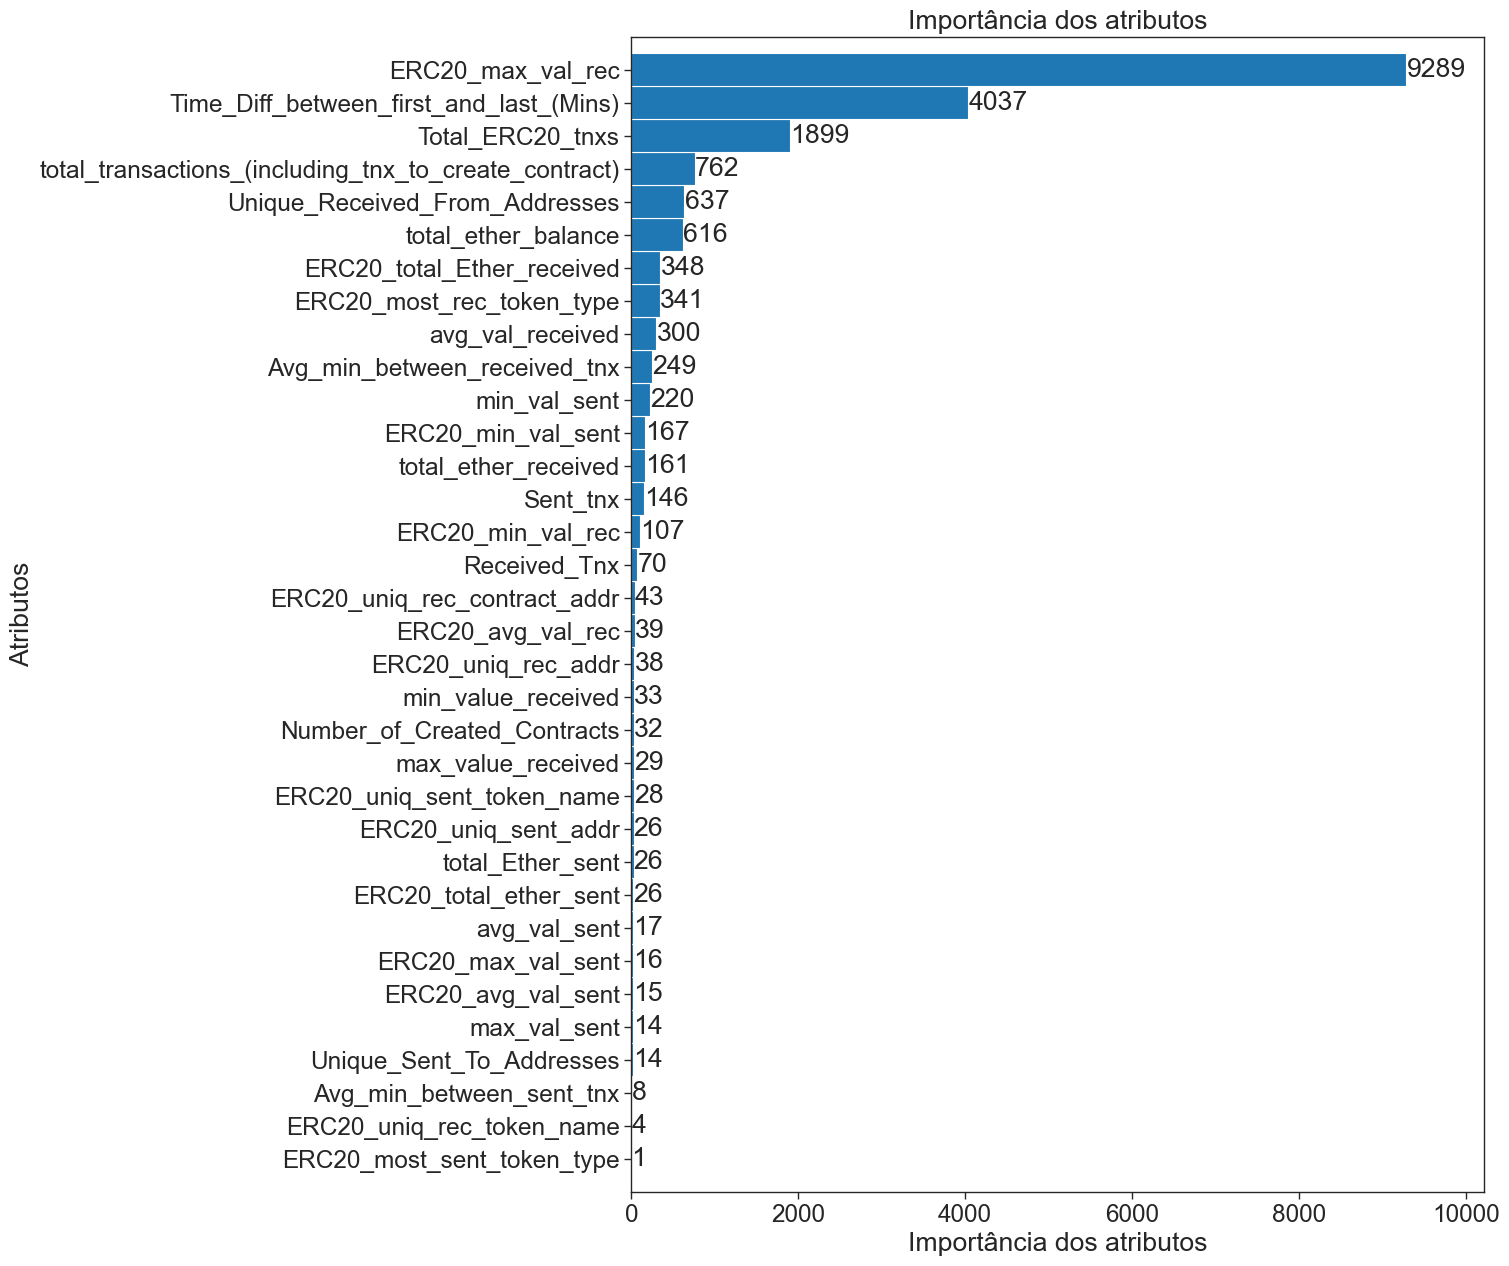

In [ ]:
plot_importance(
    classifier_lgbm_gain, height=1, xlim=None, ylim=None,
    title='Importância dos atributos', xlabel='Importância dos atributos', ylabel='Atributos', importance_type='gain',
    max_num_features=None, ignore_zero=True, figsize=(11, 15), dpi=None, grid=False, precision=0
);

In [ ]:
# create_tree_digraph(classifier_lgbm_split, tree_index=0, show_info=['data_percentage'], precision=0, orientation='vertical')
# .render(filename='g1.png')
# .view()

## Feature selection

In [ ]:
classifier_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='split', **best_gscv
)

selector = RFECV(classifier_lgbm, step=1, cv=10, scoring='roc_auc', n_jobs=-1)
selector.fit(X_train_exp_02, y_train_exp_02)

c:\PROJETOS NO GIT\01 - Carne de Pescoço\ethereum_laundering\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\PROJETOS NO GIT\01 - Carne de Pescoço\ethereum_laundering\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\PROJETOS NO GIT\01 - Carne de Pescoço\ethereum_laundering\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\PROJETOS NO GIT\01 - Carne de Pescoço\ethereum_laundering\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning:

A column-vector 

RFECV(cv=10,
      estimator=LGBMClassifier(learning_rate=0.15000000000000002, max_depth=23,
                               n_estimators=225, n_jobs=-1, num_leaves=13,
                               objective='binary', random_state=42,
                               silent='warn'),
      n_jobs=-1, scoring='roc_auc')

In [ ]:
selector.n_features_

34

In [ ]:
len(selector.ranking_)

36

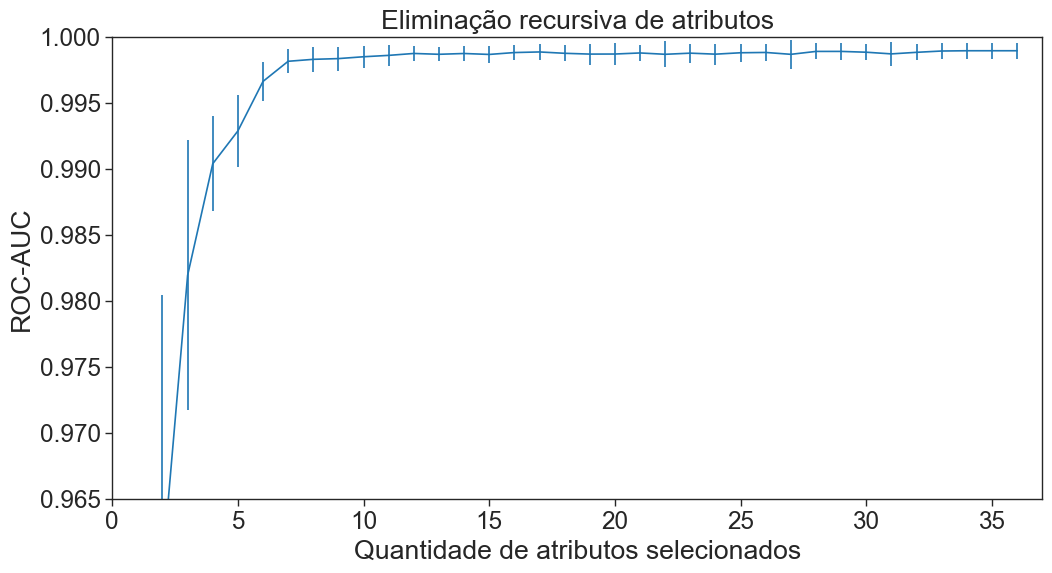

In [ ]:
n_scores = len(selector.cv_results_["mean_test_score"])

plt.figure(figsize=(12, 6))
plt.xlabel("Quantidade de atributos selecionados")
plt.ylabel("ROC-AUC")
plt.ylim(0.965, 1)
plt.xlim(0, 37)
plt.errorbar(
    range(1, n_scores + 1),
    selector.cv_results_["mean_test_score"],
    yerr=selector.cv_results_["std_test_score"],
)
plt.title("Eliminação recursiva de atributos")
plt.show()

## Evaluating the model with the testing dataset

In [ ]:
# training model AGAIN
classifier_lgbm = LGBMClassifier(
    random_state=100, n_jobs=-1, objective='binary', importance_type='importance', **best_gscv, verbosity=-1
)

classifier_lgbm.fit(X_train_exp_02, y_train_exp_02['FLAG'].values)

y_pred = classifier_lgbm.predict(X_test_exp_02)
df_cm = confusion_matrix(y_test_exp_02, y_pred)

# cm = confusion_matrix(y_test_exp_02, y_pred, labels=classifier_lgbm.classes_, normalize=None)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                             display_labels=classifier_lgbm.classes_)

# disp.plot()

# plt.show()

#### Obtendo a matriz original

In [ ]:
best_gscv = {
    'learning_rate': 0.075, 'max_depth': 4,
    'n_estimators': 275,'num_leaves': 26
    }

In [ ]:
# training model AGAIN
classifier_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, objective='binary', importance_type='gain', **best_gscv, verbosity=-1
)

classifier_lgbm.fit(X_train_exp_02, y_train_exp_02['FLAG'].values)

y_pred = classifier_lgbm.predict(X_test_exp_02)
df_cm = confusion_matrix(y_test_exp_02, y_pred)
if (df_cm[0][0] == 380) and (df_cm[1][1] == 311):
    print(f'best_gscv: {best_gscv}')
    # break
elif (df_cm[0][0] >= 380) and (df_cm[1][1] >= 311):
    print(f'best_gscv: {best_gscv} | {df_cm[0][0]} e {df_cm[1][1]}')
elif (df_cm[0][0] >= 380) or (df_cm[1][1] >= 311):
    print(f'best_gscv: {best_gscv} | {df_cm[0][0]} e {df_cm[1][1]}')

best_gscv: {'learning_rate': 0.075, 'max_depth': 4, 'n_estimators': 275, 'num_leaves': 26} | 382 e 310


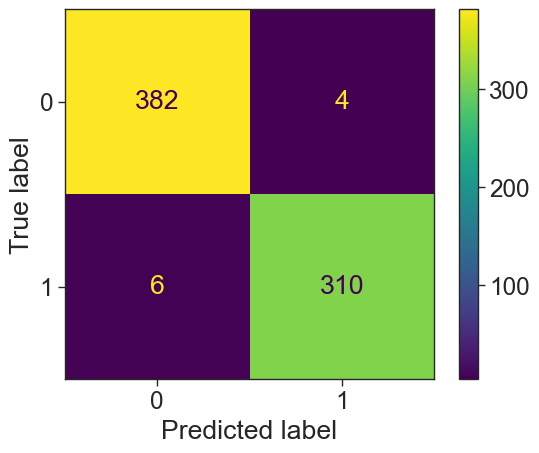

In [ ]:
cm = confusion_matrix(y_test_exp_02['FLAG'].values, y_pred, labels=classifier_lgbm.classes_, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=classifier_lgbm.classes_
    )
disp.plot()
plt.show()

### K-fold validation

In [ ]:
lst_random_seed = [1, 10, 42, 100]

In [ ]:
dct_evaluation_results = {}

for seed in lst_random_seed:
    np.random.seed(seed)
    lst_index_sampled = np.random.choice(X_test_exp_02.index, size=int(len(X_test_exp_02)*.95), replace=False).tolist()
    y_pred = classifier_lgbm.predict(X_test_exp_02.loc[lst_index_sampled, :])
    y_pred_proba = classifier_lgbm.predict_proba(X_test_exp_02.loc[lst_index_sampled, :])[::,1]
    dct_evaluation_results[seed] = {
        'seed': seed,
        'index': lst_index_sampled,
        'roc-auc': roc_auc_score(y_test_exp_02.loc[lst_index_sampled], y_pred),
        'accuracy': accuracy_score(y_test_exp_02.loc[lst_index_sampled], y_pred),
        'precision': precision_score(y_test_exp_02.loc[lst_index_sampled], y_pred),
        'recall': recall_score(y_test_exp_02.loc[lst_index_sampled], y_pred),
        'f1': f1_score(y_test_exp_02.loc[lst_index_sampled], y_pred)
    }

df_evaluation_results = pd.DataFrame.from_dict(dct_evaluation_results, orient='index')
df_evaluation_results = df_evaluation_results.loc[:, ['roc-auc', 'accuracy', 'precision', 'recall', 'f1']]

df_evaluation_results.describe().T

,count,mean,std,min,25%,50%,75%,max
roc-auc,4.00000,0.98563,0.00074,0.98454,0.98553,0.98589,0.98599,0.98620
accuracy,4.00000,0.98611,0.00075,0.98498,0.98611,0.98649,0.98649,0.98649
precision,4.00000,0.98824,0.00190,0.98658,0.98661,0.98823,0.98986,0.98993
recall,4.00000,0.98082,0.00168,0.97987,0.97997,0.98003,0.98088,0.98333
f1,4.00000,0.98451,0.00083,0.98328,0.98444,0.98490,0.98497,0.98497


In [ ]:
y_pred = classifier_lgbm.predict(X_test_exp_02)
y_pred_proba = classifier_lgbm.predict_proba(X_test_exp_02)[::,1]

In [ ]:
confusion_matrix(y_test_exp_02, y_pred)

array([[382,   4],
       [  6, 310]], dtype=int64)

In [ ]:
print(classification_report(y_test_exp_02, y_pred, digits=6))

              precision    recall  f1-score   support

           0   0.984536  0.989637  0.987080       386
           1   0.987261  0.981013  0.984127       316

    accuracy                       0.985755       702
   macro avg   0.985899  0.985325  0.985604       702
weighted avg   0.985763  0.985755  0.985751       702



### Confusion matrix

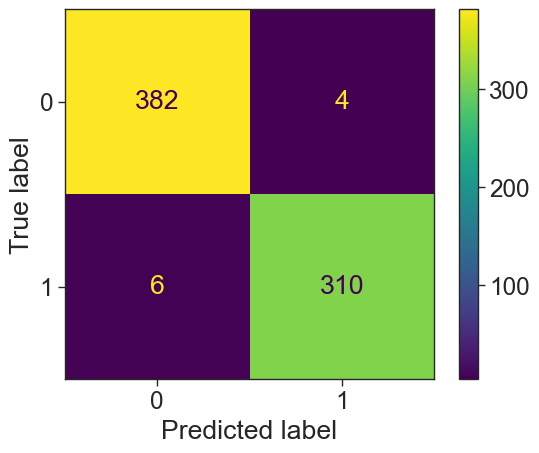

In [ ]:
cm = confusion_matrix(y_test_exp_02, y_pred, labels=classifier_lgbm.classes_, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=classifier_lgbm.classes_)

disp.plot()

plt.show()

In [ ]:
auc = round(roc_auc_score(y_test_exp_02, y_pred, labels=classifier_lgbm.classes_), 5)
auc

0.98532

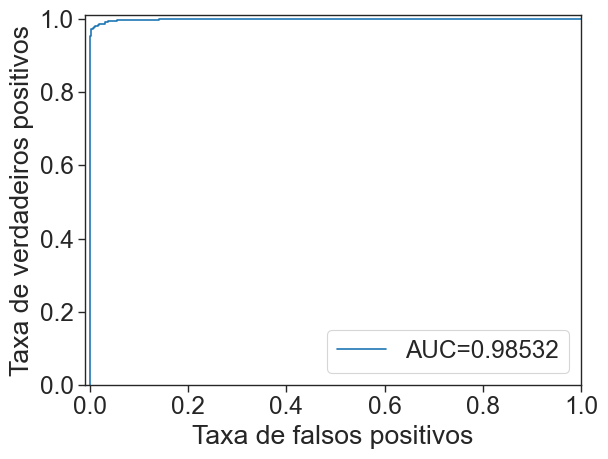

In [ ]:
fpr, tpr, threshold = roc_curve(y_test_exp_02, y_pred_proba, drop_intermediate=True)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Taxa de verdadeiros positivos')
plt.xlabel('Taxa de falsos positivos')
plt.xlim(-0.01,1)
plt.ylim(0,1.01)
plt.legend(loc=4)
plt.show()

### Extraindo para excel

In [ ]:
pd.concat([pd.Series(fpr, name='fpr'), pd.Series(tpr, name='tpr'), pd.Series(threshold, name='threshold'),], axis=1).to_excel('../data/processed/FPR vs TPR.xlsx', index=False)

### Wallets classified wrongly

In [ ]:
df_wallets_misclassified = pd.concat([pd.DataFrame(y_pred, index=y_test_exp_02.index, columns=['pred']), y_test_exp_02], axis=1)

conditions = [
    (df_wallets_misclassified['pred'] == 1) & (df_wallets_misclassified['FLAG']==1),
    (df_wallets_misclassified['pred'] == 0) & (df_wallets_misclassified['FLAG']==0),
    (df_wallets_misclassified['pred'] == 1) & (df_wallets_misclassified['FLAG']==0),
    (df_wallets_misclassified['pred'] == 0) & (df_wallets_misclassified['FLAG']==1),
]

choices = [
    'Verdadeiro positivo',
    'Verdadeiro negativo',
    'Falso positivo',
    'Falso negativo',
]

df_wallets_misclassified['Resultado'] = np.select(conditions, choices, 'errei')

if len(df_wallets_misclassified.loc[df_wallets_misclassified['Resultado']=='errei', :]) == 0:
    print("Não errei!")
    
df_wallets_misclassified = df_wallets_misclassified.loc[
    df_wallets_misclassified['Resultado'].isin(['Falso positivo','Falso negativo',])
]

Não errei!


In [ ]:
df_wallets_misclassified = pd.merge(
    df_wallets_misclassified.loc[:, 'Resultado'],
    df_raw.loc[:, ['Address']],
    left_index=True, right_index=True
)

df_wallets_misclassified.to_excel(PROCESSED_FOLDER + 'wallets_misclassified.xlsx', index=False)

df_wallets_misclassified.sort_values(by=['Resultado'])

,Resultado,Address
1849,Falso negativo,0xd9cd7461f960e56364a294f124aac77b25e2b784
911,Falso negativo,0x684ede6645f1b71d77e0aeac519114ee8be3c410
1371,Falso negativo,0x9f4562c9be26c7020909b50ccde3447f1b8c4b21
1832,Falso negativo,0xd808259ca07fdf4d8fa825c4704f624352e2dc14
877,Falso negativo,0x63cfa80bbbee233a4257857dcdc9d78cbc8efe37
960,Falso negativo,0x6ddfef85ecf643628254e5af7064e05b3c6b221e
2716,Falso positivo,0x6d57fe045dcced8b289db59f66cd4354b6483d63
3560,Falso positivo,0x1c3f580daeaac2f540c998c8ae3e4b18440f7c45
3750,Falso positivo,0x44261fd8b6579ffb751569f859bc1225af0c5f2c
2988,Falso positivo,0xa44643642141c2af4fb52cd320821ddfa1ad12fb
